In [1]:
import csv
import gzip
import random
import sqlite3
import sys
import time
import itertools
import json
import numpy as np
import colorspacious
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SeparableConv1D, Activation
import tensorflow as tf
import sklearn.utils
import matplotlib.pyplot as plt
import numba

In [2]:
# Force CPU operation for deterministic and reproducible results
# Disable parallelism per https://github.com/NVIDIA/framework-determinism/blob/28091e4fb1483685fc78b7ab844a5ae6ddf55a14/README.md#cpu
tf.config.set_visible_devices([], "GPU")
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [3]:
# Needed for deterministic results
SEED = 567687
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
with open("top-sets.json") as infile:
    TOP_SETS_RGB = json.load(infile)
TOP_SETS_RGB = {int(i): TOP_SETS_RGB[i] for i in TOP_SETS_RGB}
ALL_NUM_COLORS = TOP_SETS_RGB.keys()
DB_FILE = "../survey-results/results.db"

In [5]:
npz = np.load("../color-name-model/colornamemodel.npz")
COLOR_NAMES = list(npz["names"])
BCT_IDX = npz["bct_idxs"]
COLOR_NAME_IDX = npz["name_idxs"]

In [6]:
ENSEMBLE_COUNT = 100

## Color conversion and sorting functions

Data are all stored as 8-bit RGB values and need to be converted to CAM02-UCS.

We also need to be able to sort along the three CAM02-UCS axes.

In [7]:
def to_jab(color):
    """
    Convert hex color code (without `#`) to CAM02-UCS.
    """
    rgb = [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in color]
    jab = [colorspacious.cspace_convert(i, "sRGB255", "CAM02-UCS") for i in rgb]
    return np.array(jab)


def sort_colors_by_j(colors):
    """
    Sorts colors by CAM02-UCS J' axis.
    """
    return colors[np.lexsort(colors[:, ::-1].T, 0)]


def sort_colors_by_a(colors):
    """
    Sorts colors by CAM02-UCS a' axis.
    """
    return colors[np.argsort(colors[:, ::-1].T[1])]


def sort_colors_by_b(colors):
    """
    Sorts colors by CAM02-UCS b' axis.
    """
    return colors[np.argsort(colors[:, ::-1].T[2])]

## Data loading

Survey data are loaded from a SQLite database, and the complete set of color sets is loaded from a text file. The 8-bit RGB values are converted to CAM02-UCS and sorted along the three CAM02-UCS axes.

In [8]:
# Load survey data
cycle_data = {}
cycle_targets = {}
min_count = 1e10

conn = sqlite3.connect(DB_FILE)
c = conn.cursor()

for num_colors in ALL_NUM_COLORS:
    count = 0
    cycle_data[num_colors] = []
    cycle_targets[num_colors] = []
    for row in c.execute(
        f"SELECT c1, c2, o, cp, sp FROM picks WHERE length(c1) = {num_colors * 7 - 1}"
    ):
        count += 1
        orders = [[int(c) for c in o] for o in row[2].split(",")]
        # Convert to Jab [CAM02-UCS based]
        jab1 = to_jab(row[0].split(","))
        jab2 = to_jab(row[1].split(","))
        # Add cycle data
        for i in range(4):
            if i != row[3] - 1:
                cycle_data[num_colors].append(
                    np.array((jab1[orders[row[3] - 1]], jab2[orders[i]])).flatten()
                )
                cycle_targets[num_colors].append(0)
    cycle_data[num_colors] = np.array(cycle_data[num_colors])
    cycle_targets[num_colors] = np.array(cycle_targets[num_colors])
    min_count = min(min_count, count)
    print(num_colors, count)

conn.close()

6 10347
8 10371
10 1705


In [9]:
# Convert color set data
TOP_SETS = {}
for num_colors in ALL_NUM_COLORS:
    TOP_SETS[num_colors] = to_jab(TOP_SETS_RGB[num_colors]).flatten()

In [10]:
# Best color set
orderings = {}
orderings_rgb = {}
for num_colors in ALL_NUM_COLORS:
    orderings[num_colors] = np.array(
        list(itertools.permutations(TOP_SETS[num_colors].reshape(-1, 3)))
    ).reshape(-1, 3 * num_colors)
    orderings_rgb[num_colors] = np.array(
        list(itertools.permutations(TOP_SETS_RGB[num_colors]))
    )

In [11]:
def construct_network(num_colors):
    #
    # Construct network
    #
    conv_size = 5

    layer1 = Dense(units=5, activation="elu", name="l1")
    layer2 = Dense(units=5, activation="elu", name="l2")

    layer3 = SeparableConv1D(5, conv_size, padding="same", activation="elu", name="l3")
    layer4 = SeparableConv1D(3, conv_size, padding="same", activation="elu", name="l4")
    layer5 = SeparableConv1D(1, conv_size, padding="same", activation="elu", name="l5")

    # Create network
    input_a = Input(shape=(3 * num_colors,))
    inputs_a = [input_a[:, i * 3 : (i + 1) * 3] for i in range(num_colors)]

    # Share layers between colors
    x_a = [layer1(i / 100) for i in inputs_a]
    x_a = [layer2(i) for i in x_a]

    # Combine colors into sets
    x_a = tf.keras.layers.concatenate(
        [tf.keras.backend.expand_dims(i, 1) for i in x_a], axis=1
    )

    # Share layers between color sets
    x_a = layer3(x_a)
    x_a = layer4(x_a)
    x_a = layer5(x_a)

    # Average outputs
    x_a = tf.math.reduce_mean(x_a, axis=1)

    # Final non-linear activation
    layer_nm1 = Activation("sigmoid", name=f"score{num_colors}")
    x_a = layer_nm1(x_a)

    # For evaluation
    return Model(inputs=input_a, outputs=x_a)

In [12]:
scoring_model = {nc: construct_network(nc) for nc in ALL_NUM_COLORS}

## Evaluate model accuracy

Scores are compared to calculate model accuracy. All data are used (no train / test split).

As the ten-color data were not used during design, hyperparameter tuning, or training, they serve as a validation set. These data were only evaluated after the model was finalized.

In [13]:
survey_scores_a = {nc: [] for nc in ALL_NUM_COLORS}
survey_scores_b = {nc: [] for nc in ALL_NUM_COLORS}
for nc in ALL_NUM_COLORS:
    for i in range(ENSEMBLE_COUNT):
        with gzip.open(f"weights/cycle_model_weights_{i:03d}.h5.gz", "rb") as infile:
            infile.endswith = lambda x: x == ".h5"  # Monkey-patch for format detection
            scoring_model[nc].load_weights(infile, by_name=True)
        survey_scores_a[nc].append(
            scoring_model[nc].predict(cycle_data[nc][:, : nc * 3]).flatten()
        )
        survey_scores_b[nc].append(
            scoring_model[nc].predict(cycle_data[nc][:, nc * 3 :]).flatten()
        )
    survey_scores_a[nc] = np.array(survey_scores_a[nc])
    survey_scores_b[nc] = np.array(survey_scores_b[nc])

In [14]:
for nc in ALL_NUM_COLORS:
    acc = np.mean((survey_scores_a[nc] > survey_scores_b[nc]) ^ cycle_targets[nc])
    print(f"accuracy {nc:2d}: {acc:.5f}")

accuracy  6: 0.53609
accuracy  8: 0.53877
accuracy 10: 0.52200


## Predict scores for full set of color sets

A score is predicted for each color set in the full set of color sets. Furthermore, the variability within the ensemble is also evaluated.

In [15]:
# Score color cycles
scores = {nc: [] for nc in ALL_NUM_COLORS}
for nc in ALL_NUM_COLORS:
    for i in range(ENSEMBLE_COUNT):
        with gzip.open(f"weights/cycle_model_weights_{i:03d}.h5.gz", "rb") as infile:
            infile.endswith = lambda x: x == ".h5"  # Monkey-patch for format detection
            scoring_model[nc].load_weights(infile, by_name=True)
        scores[nc].append(scoring_model[nc].predict(orderings[nc]).flatten())
    scores[nc] = np.array(scores[nc])

In [16]:
cycle_scores = {}
for nc in ALL_NUM_COLORS:
    bootstrap = np.array(
        [np.mean(sklearn.utils.resample(scores[nc]), axis=0) for _ in range(1000)]
    )
    cycle_scores[f"mean{nc:02d}"] = scores[nc].mean(axis=0)
    cycle_scores[f"error{nc:02d}"] = bootstrap.std(axis=0)

## Calculate final cycle scores

The final cycle scores combine the machine learning derived scores with a perceptual distance score and a luminance distance score. These scores are calculated to favor cycles that include easier to differentiate colors at the beginning of the cycle, both for color and grayscale. Additionally, only cycles that do not contain two colors in the first half of the cycle that would be identified by the same basic color term are considered.

In [17]:
top_cycles = {}

In [18]:
def to_jab_cvd(color):
    rgb255 = [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in color]
    rgb = [
        (int(i[:2], 16) / 255, int(i[2:4], 16) / 255, int(i[4:], 16) / 255)
        for i in color
    ]
    jab = [colorspacious.cspace_convert(i, "sRGB1", "CAM02-UCS") for i in rgb]
    jab_deut = [
        colorspacious.cspace_convert(
            i,
            {"name": "sRGB1+CVD", "cvd_type": "deuteranomaly", "severity": 100},
            "CAM02-UCS",
        )
        for i in rgb
    ]
    jab_prot = [
        colorspacious.cspace_convert(
            i,
            {"name": "sRGB1+CVD", "cvd_type": "protanomaly", "severity": 100},
            "CAM02-UCS",
        )
        for i in rgb
    ]
    jab_trit = [
        colorspacious.cspace_convert(
            i,
            {"name": "sRGB1+CVD", "cvd_type": "tritanomaly", "severity": 100},
            "CAM02-UCS",
        )
        for i in rgb
    ]
    return (
        np.array(rgb255),
        np.array(jab),
        np.array(jab_deut),
        np.array(jab_prot),
        np.array(jab_trit),
    )

In [19]:
@numba.njit
def cam02de(c1, c2):
    diff = np.abs(c1 - c2)
    return np.sqrt(np.sum(diff * diff))

In [20]:
BCT_IDX_WHITE = COLOR_NAMES.index("white")

In [21]:
@numba.njit
def score_permuations(
    permutations, set_rgb, set_jab, set_jab_deut, set_jab_prot, set_jab_trit
):
    unique_name_count = len(
        set([BCT_IDX[i[0] + i[1] * 256 + i[2] * 256 ** 2] for i in set_rgb[1:]])
    )
    permutation_scores = []
    for order in permutations:
        # Score cycle by calculating minimum perceptual distance as each color is added and averaging distances
        dists = []
        color_names = [BCT_IDX_WHITE]
        dist = 1000
        J_dist = 1000
        name_score = True
        for i in range(1, len(set_jab)):
            j = order[i - 1] + 1
            for k in [0] + list(order[: i - 1] + 1):
                dist = min(dist, cam02de(set_jab[j], set_jab[k]))
                dist = min(dist, cam02de(set_jab_deut[j], set_jab_deut[k]))
                dist = min(dist, cam02de(set_jab_prot[j], set_jab_prot[k]))
                dist = min(dist, cam02de(set_jab_trit[j], set_jab_trit[k]))
                J_dist = min(J_dist, abs(set_jab[j][0] - set_jab[k][0]))

            color_names.append(
                BCT_IDX[set_rgb[j, 0] + set_rgb[j, 1] * 256 + set_rgb[j, 2] * 256 ** 2]
            )
            if (
                i < len(set_jab) - 1
                and i <= unique_name_count
                and len(set(color_names)) < len(color_names)
            ):
                name_score = False
                break

            dists.append(dist * J_dist)
        if name_score:
            permutation_scores.append(
                np.mean(np.array(dists, dtype=np.float64))
            )  # Order score (higher is better)
        else:
            permutation_scores.append(
                0.0
            )  # Duplicate color name in first half of cycle
    return np.array(permutation_scores)

### Six colors

In [22]:
set_rgb, set_jab, set_jab_deut, set_jab_prot, set_jab_trit = to_jab_cvd(
    ["ffffff"] + TOP_SETS_RGB[6]
)

In [23]:
permutations = np.array(list(itertools.permutations(np.arange(6))))
scores_mean = np.mean(scores[6], axis=0)
with_same_first_color = permutations[:, 0] == permutations[np.argmax(scores_mean)][0]
permutations = permutations[with_same_first_color]
scores_mean = scores_mean[with_same_first_color]

In [24]:
permutation_scores = score_permuations(
    permutations, set_rgb, set_jab, set_jab_deut, set_jab_prot, set_jab_trit
)
print(np.sum(permutation_scores > 0))

48


In [25]:
cycle_scores["first06"] = with_same_first_color
cycle_scores["access06"] = permutation_scores.astype(np.float32)

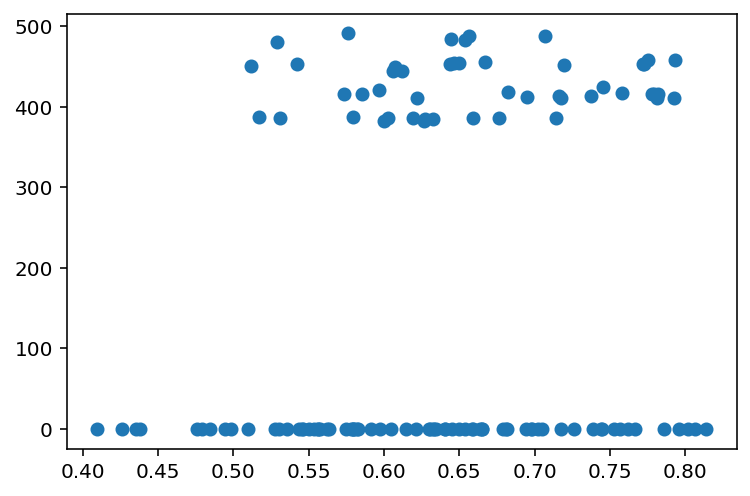

In [26]:
plt.scatter(scores_mean, permutation_scores)

In [27]:
tallies6 = permutation_scores * scores_mean
np.where(tallies6 == np.max(tallies6))

(array([117]),)

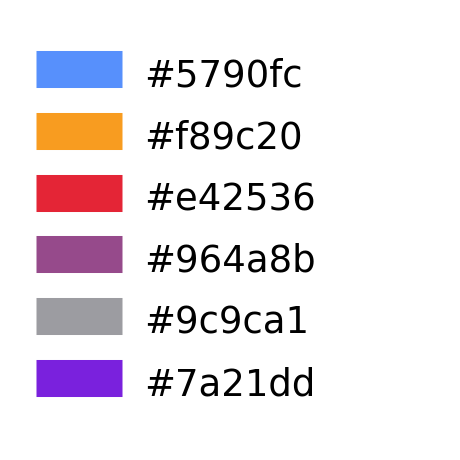

In [28]:
idx = np.where(tallies6 == np.sort(np.unique(tallies6))[-1])[0][0]
n = len(orderings_rgb[6][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(orderings_rgb[6][with_same_first_color][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

In [29]:
tmp = orderings_rgb[6][with_same_first_color][idx]
top_cycles[6] = list(tmp)
print("Names:")
for i in range(6):
    i = COLOR_NAME_IDX[
        int(tmp[i][0:2], 16)
        + int(tmp[i][2:4], 16) * 256
        + int(tmp[i][4:], 16) * 256 ** 2
    ]
    print(i, COLOR_NAMES[i])

Names:
1 blue
6 orange
3 red
2 purple
10 gray
2 purple


### Eight colors

In [30]:
set_rgb, set_jab, set_jab_deut, set_jab_prot, set_jab_trit = to_jab_cvd(
    ["ffffff"] + TOP_SETS_RGB[8]
)

In [31]:
permutations = np.array(list(itertools.permutations(np.arange(8))))
scores_mean = np.mean(scores[8], axis=0)
with_same_first_color = permutations[:, 0] == permutations[np.argmax(scores_mean)][0]
permutations = permutations[with_same_first_color]
scores_mean = scores_mean[with_same_first_color]

In [32]:
permutation_scores = score_permuations(
    permutations, set_rgb, set_jab, set_jab_deut, set_jab_prot, set_jab_trit
)
print(np.sum(permutation_scores > 0))

288


In [33]:
cycle_scores["first08"] = with_same_first_color
cycle_scores["access08"] = permutation_scores.astype(np.float32)

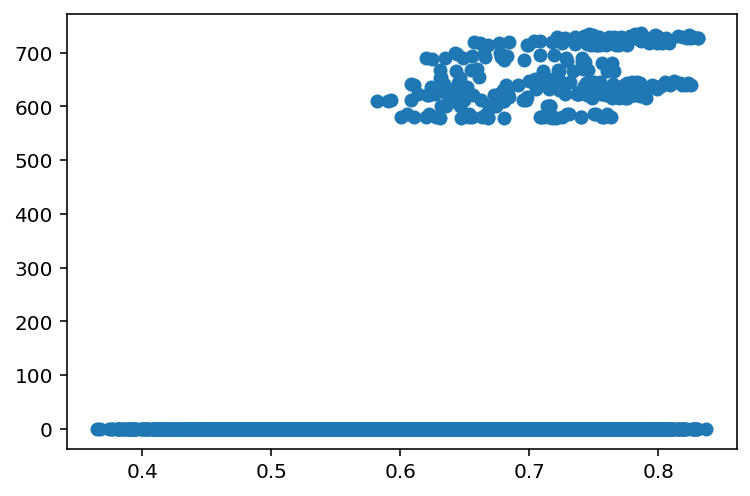

In [34]:
plt.scatter(scores_mean, permutation_scores)

In [35]:
tallies8 = permutation_scores * scores_mean
np.where(tallies8 == np.max(tallies8))

(array([5038]),)

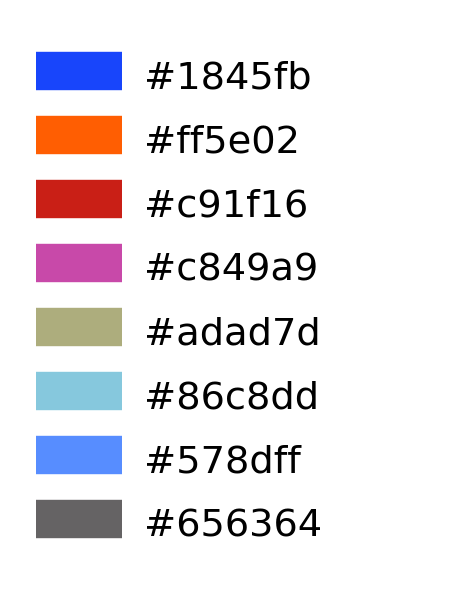

In [36]:
idx = np.where(tallies8 == np.sort(np.unique(tallies8))[-1])[0][0]
n = len(orderings_rgb[8][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(orderings_rgb[8][with_same_first_color][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

In [37]:
tmp = orderings_rgb[8][with_same_first_color][idx]
top_cycles[8] = list(tmp)
print("Names:")
for i in range(8):
    i = COLOR_NAME_IDX[
        int(tmp[i][0:2], 16)
        + int(tmp[i][2:4], 16) * 256
        + int(tmp[i][4:], 16) * 256 ** 2
    ]
    print(i, COLOR_NAMES[i])

Names:
1 blue
6 orange
3 red
2 purple
10 gray
9 light blue
1 blue
10 gray


### Ten colors

In [38]:
set_rgb, set_jab, set_jab_deut, set_jab_prot, set_jab_trit = to_jab_cvd(
    ["ffffff"] + TOP_SETS_RGB[10]
)

In [39]:
permutations = np.array(list(itertools.permutations(np.arange(10))))
scores_mean = np.mean(scores[10], axis=0)
with_same_first_color = permutations[:, 0] == permutations[np.argmax(scores_mean)][0]
permutations = permutations[with_same_first_color]
scores_mean = scores_mean[with_same_first_color]

In [40]:
permutation_scores = score_permuations(
    permutations, set_rgb, set_jab, set_jab_deut, set_jab_prot, set_jab_trit
)
print(np.sum(permutation_scores > 0))

23040


In [41]:
cycle_scores["first10"] = with_same_first_color
cycle_scores["access10"] = permutation_scores.astype(np.float32)

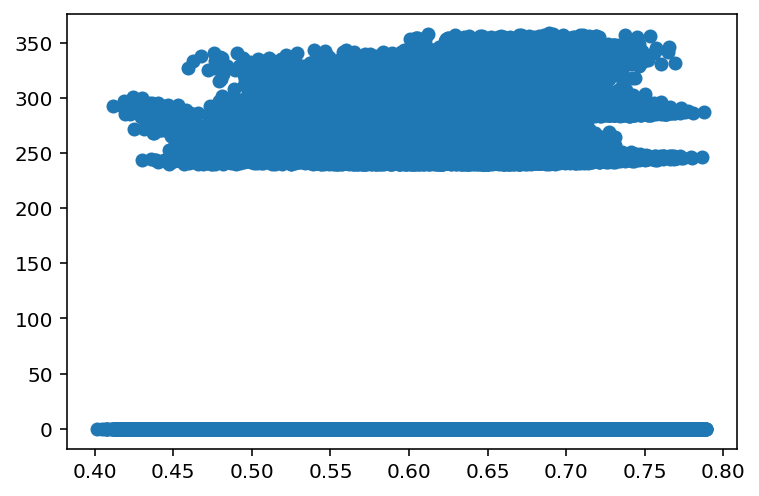

In [42]:
plt.scatter(scores_mean, permutation_scores)

In [43]:
tallies10 = permutation_scores * scores_mean
np.where(tallies10 == np.max(tallies10))

(array([355150]),)

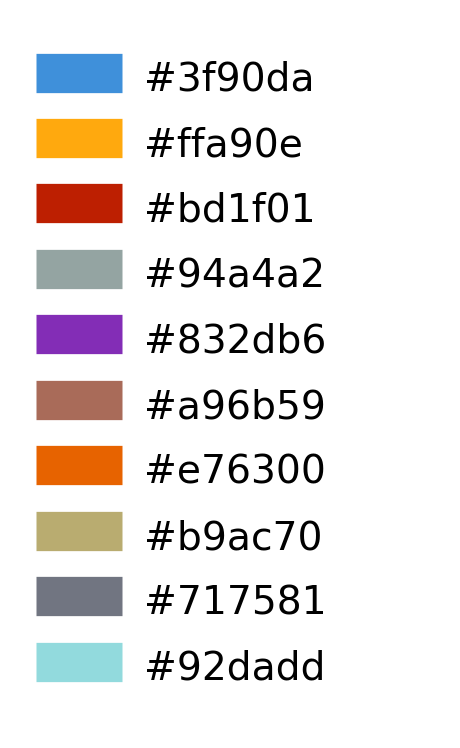

In [44]:
idx = np.where(tallies10 == np.sort(np.unique(tallies10))[-1])[0][0]
n = len(orderings_rgb[10][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(orderings_rgb[10][with_same_first_color][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

In [45]:
tmp = orderings_rgb[10][with_same_first_color][idx]
top_cycles[10] = list(tmp)
print("Names:")
for i in range(10):
    i = COLOR_NAME_IDX[
        int(tmp[i][0:2], 16)
        + int(tmp[i][2:4], 16) * 256
        + int(tmp[i][4:], 16) * 256 ** 2
    ]
    print(i, COLOR_NAMES[i])

Names:
1 blue
6 orange
3 red
10 gray
2 purple
7 brown
6 orange
20 tan
10 gray
9 light blue


### Save results

In [46]:
np.savez_compressed('cycle-scores.npz', **cycle_scores)
with open('top-cycles.json', 'w') as outfile:
    json.dump(top_cycles, outfile)